### Drift tool Cartopy implementation

A sample set of functions to explore moving from Basemap to Cartopy 0.18 (used by OpenDrift)

Sample data is stored here: /gpfs/fs4/dfo/dpnm/dfo_dpnm/jeh326/projects/cartopy_implementation/sample_input_data/
My environment has the following packages installed: /gpfs/fs4/dfo/dpnm/dfo_dpnm/jeh326/projects/cartopy_implementation/sample_input_data/cartopy_env-installed_packages.txt

In [11]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import os
import cmocean
from matplotlib.pylab import cm
import pylab as pl
import matplotlib

%matplotlib inline

# this bit of code stretches the code window out to the full size of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
# load the drift-tool output
projectdir = "C:/Users/Holdenje/DRIFT/projects/cartopy_implementation/"
dt_datadir = os.path.join(projectdir, "sample_dt_output/ciopse/")
misc_datadir = os.path.join(projectdir, "misc_files/")
bathymetry_file = os.path.join(misc_datadir, "ETOPO1_Bed_g_gmt4.grd")
nc_bathyfile = os.path.join(misc_datadir, "etopo1.nc")

#Load the sample data
dtfile = xr.open_dataset(os.path.join(dt_datadir, "300D20211010H10_aggregated.nc"))

#define some variables
time = dtfile.time.values
obslat = dtfile.obs_lat[0].values
obslon = dtfile.obs_lon[0].values
modlat = dtfile.mod_lat[0].values
modlon = dtfile.mod_lon[0].values

#grab data from attributes
buoyid = dtfile.obs_buoyid
mod_start_lon = dtfile.mod_start_lon
mod_start_lat = dtfile.mod_start_lat
mod_start_date = dtfile.mod_start_date

#find the data min/max
all_lons = list(modlon) + list(obslon)
all_lats = list(modlat) + list(obslat)
data_bbox_info = {
    'minlon': np.nanmin(all_lons),
    'maxlon': np.nanmax(all_lons),
    'minlat': np.nanmin(all_lats),
    'maxlat': np.nanmax(all_lats),
    'meanlon': np.nanmean(all_lons),
    'meanlat': np.nanmean(all_lats)
}

The following are a couple of functions from the drift tool that are called by the drift tool bathymetry function:

In [13]:
# drift tool functions that are needed for the bathymetry functions in the next cell:

from collections import namedtuple
LatLonBoundingBox = namedtuple('LatLonBoundingBox', ('lat_min', 'lat_max', 'lon_min', 'lon_max'))

def LevelColormap(levels, cmap=None):
    """Make a colormap based on an increasing sequence of levels"""

    # Start with an existing colormap
    if cmap == None:
        cmap = pl.get_cmap()

    # Spread the colours maximally
    nlev = len(levels)
    S = pl.arange(nlev, dtype='float')/(nlev-1)
    A = cmap(S)

    # Normalize the levels to interval [0,1]
    levels = pl.array(levels, dtype='float')
    L = (levels-levels[0])/(levels[-1]-levels[0])

    # Make the colour dictionary
    R = [(L[i], A[i,0], A[i,0]) for i in range(nlev)]
    G = [(L[i], A[i,1], A[i,1]) for i in range(nlev)]
    B = [(L[i], A[i,2], A[i,2]) for i in range(nlev)]
    cdict = dict(red=tuple(R),green=tuple(G),blue=tuple(B))
    
    return matplotlib.colors.LinearSegmentedColormap(
        '%s_levels' % cmap.name, cdict, 256)

def find_subset_indices(lat_min, lat_max, lon_min, lon_max, lats, lons):
    """Finds indices in the arrays lats and lons containing the specified box.
       This function is called in the plot_bathemetry module.
    
    Parameters
    ----------
    lat_min : float
    lat_max : float
    lon_min : float
    lon_max : floatimport matplotlib
    lats : numpy.ndarray
    lons : numpy.ndarray

    Returns
    -------
    LatLonBoundingBox
        The integer indices specified as a dictionary with keys 'lat_min',
        'lat_max', 'lon_min', and 'lon_max'.
    """
    distances1 = []
    distances2 = []
    index = 1

    for point in lats:
        s1 = lat_max - point
        s2 = lat_min - point
        distances1.append((s1 * s1, point, index))
        distances2.append((s2 * s2, point, index - 1))
        index = index + 1

    distances1.sort()
    distances2.sort()
    ilat_max = distances1[0][2]
    ilat_min = distances2[0][2]

    distances1 = []
    distances2 = []
    index = 1

    for point in lons:
        s1 = lon_max - point
        s2 = lon_min - point
        distances1.append((s1 * s1, point, index))
        distances2.append((s2 * s2, point, index - 1))
        index = index + 1

    distances1.sort()
    distances2.sort()
    ilon_max = distances1[0][2]
    ilon_min = distances2[0][2]

    return LatLonBoundingBox(lon_min=ilon_min, lat_min=ilat_min,
                             lon_max=ilon_max, lat_max=ilat_max)

def alternate_streamlined_plot_bathymetry(bathymetry_file, ax, bbox, colorbar_visible = False):
    """Plot topography/bathymetry on the given basemap.

    Parameters
    ----------
    bathymetry_file : str
        Name of netCDF containing bathymetry data.
    basemap : Basemap
        Basemap on which to plot the bathymetry contours.
    bbox : LatLonBoundingBox
        Bounding box for plot in terms of lat/lon.
    """

    # Read in ETOPO1 topography/bathymetry.
    # http://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd.gz
    etopo = xr.open_dataset(bathymetry_file)
    etopo = etopo.sel(x=slice(bbox[0],bbox[1]), y=slice(bbox[2],bbox[3]))
    lats = etopo.y
    lons = etopo.x
    bathy = etopo.z
    
    levels = [-16000,-14000,-12000,-11000,-10000, -9000, -8000, -6000, -5000, -3000, -2000, -1500, -1000, -500, -400, -300, -250, -200, -150, -100, -75, -65, -50, -35, -25, -15, 0]
    contour_set = ax.contourf(lons, lats, bathy, levels, cmap=LevelColormap(levels, cmap=cm.Blues_r), transform=proj, extend='both', origin='lower', alpha=1.0)
    contour_set.axis = 'tight'

    #commented out because we don't need the contours in the plot
    #basemap.contour(x, y, bathy, levels=[-500, -250], extend='neither', linewidths=0.05, linestyles='solid', colors='k')

    if colorbar_visible is True:
        colorbar = plt.colorbar(contour_set, label='Depth (m)')
        for t in colorbar.ax.get_yticklabels():
            t.set_fontsize(9)



These functions are new or modified versions of functions from the drift tool. The bathymetry function has the code removed that deals with cached data, but it should be re-added inside the drift tool.

In [26]:
# These are the bathymetry functions that I'm actually calling:

def format_parallels_and_meridians(parfmt, merfmt):
    '''
    functions pulled from the source code for cartopy.mpl.gridliner 
    (https://scitools.org.uk/cartopy/docs/v0.15/_modules/cartopy/mpl/gridliner.html)
    (https://github.com/SciTools/cartopy/blob/master/lib/cartopy/mpl/gridliner.py#L93)
    The functions are modified slightly to reduce the number of significant digits
    
    An example of how to modify gridlines and labels can be found: 
    https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
    
    parfmt : str
        format string that defines how many decimal places will be 
        plotted for the parallel labels
    merfmt : str
        format string that defines how many decimal places will be 
        plotted for the meridian labels
    '''
    _DEGREE_SYMBOL = u'\u00B0'

    def _fix_lons(lons):
        """Fix the given longitudes into the range ``[-180, 180]``."""
        lons = np.array(lons, copy=False, ndmin=1)
        fixed_lons = ((lons + 180) % 360) - 180
        # Make the positive 180s positive again.
        fixed_lons[(fixed_lons == -180) & (lons > 0)] *= -1
        return fixed_lons

    def _lon_heimisphere(longitude):
        """Return the hemisphere (E, W or '' for 0) for the given longitude."""
        longitude = _fix_lons(longitude)
        if longitude > 0:
            hemisphere = 'E'
        elif longitude < 0:
            hemisphere = 'W'
        else:
            hemisphere = ''
        return hemisphere

    def _lat_heimisphere(latitude):
        """Return the hemisphere (N, S or '' for 0) for the given latitude."""
        if latitude > 0:
            hemisphere = 'N'
        elif latitude < 0:
            hemisphere = 'S'
        else:
            hemisphere = ''
        return hemisphere

    def _east_west_formatted(longitude, num_format='g'):
        fmt_string = u'{longitude:{num_format}}{degree}{hemisphere}'
        return fmt_string.format(longitude=abs(longitude), num_format=merfmt,
                             hemisphere=_lon_heimisphere(longitude),
                             degree=_DEGREE_SYMBOL)

    def _north_south_formatted(latitude, num_format='g'):
        fmt_string = u'{latitude:{num_format}}{degree}{hemisphere}'
        return fmt_string.format(latitude=abs(latitude), num_format=parfmt,
                             hemisphere=_lat_heimisphere(latitude),
                             degree=_DEGREE_SYMBOL)

    #: A formatter which turns longitude values into nice longitudes such as 110W
    LONGITUDE_FORMATTER = mticker.FuncFormatter(lambda v, pos:
                                            _east_west_formatted(v))
    #: A formatter which turns longitude values into nice longitudes such as 45S
    LATITUDE_FORMATTER = mticker.FuncFormatter(lambda v, pos:
                                           _north_south_formatted(v))

    return LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def draw_parallels_and_meridians(ax, bbox, dataproj=ccrs.PlateCarree()):

    minlons = bbox[0]
    maxlons = bbox[1]
    minlats = bbox[2]
    maxlats = bbox[3]

    if maxlons-minlons < 6:
        merfmt = '.1f'
        merrotamt = 0 
        rangestep = (maxlons-minlons)/4
        shiftstep = rangestep/2
        merrange = np.arange(minlons+shiftstep, maxlons+shiftstep, rangestep)
    else:
        merfmt = '.0f'
        merrotamt = 0
        rangestep = (np.floor(maxlons)-np.ceil(minlons))/6
        shiftstep = rangestep/2
        fmerrange = np.arange(np.ceil(minlons-shiftstep), np.floor(maxlons-shiftstep), rangestep)
        merrange = np.append(fmerrange, [fmerrange[-1] + rangestep])

    if maxlats-minlats < 6:
        parfmt = '.1f'
        parrotamt = 90
        rangestep = (maxlats-minlats)/4
        shiftstep = rangestep/2
        parrange = np.arange(minlats+shiftstep, maxlats+shiftstep, rangestep)
    else:
        parfmt = '.0f'
        parrotamt = 90
        rangestep = (np.floor(maxlats)-np.ceil(minlats))/6
        shiftstep = rangestep/2
        fparrange = np.arange(np.ceil(minlats-shiftstep), np.floor(maxlats-shiftstep), rangestep)
        parrange = np.append(fparrange, [fparrange[-1] + rangestep])
   
    # Add gridlines and labels. Set alpha=0.5 to enable the interior gridlines and alpha=0.0 to remove them.
    # Alternately, can use gl.xlines = False to turn off specific gridlines.
    gl = ax.gridlines(crs=dataproj, draw_labels=True, linewidth=1, color='black', alpha=0.1, linestyle='--', x_inline=False, y_inline=False)
    
    # Set the gridline spacing based on values above. Alternately, to only place labels in specific spaces use:
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.ylocator = mticker.FixedLocator(parrange)
    gl.xlocator = mticker.FixedLocator(merrange)
    
    # Disable the top and right grid line labels.
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels= False
    gl.bottom_labels = True
        
    # nicely format the tick marks (ie 50N, 50W, etc)
    LONGITUDE_FORMATTER, LATITUDE_FORMATTER = format_parallels_and_meridians(parfmt, merfmt)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Add axis labels and format them. Currently, cartopy 0.18 ignores the instruction to rotate the tick labels and just
    # rotates them or not as it sees fit. This is fixed in version 0.2.0.
    gl.xlabel_style = {'size': 12, 'color': 'black', 'rotation':merrotamt, 'weight': 'normal', 'ha':'center'}
    gl.ylabel_style = {'size': 12, 'color': 'black', 'rotation':parrotamt, 'weight': 'normal', 'ha': 'center'}
    
    # Add gridline text labels.
    ax.text(-0.08, 0.55, 'Longitude'u' [\N{DEGREE SIGN}]', va='bottom', ha='center', rotation='vertical', size=14, rotation_mode='anchor', transform=ax.transAxes, color='black')
    ax.text(0.5, -0.075, 'Latitude'u' [\N{DEGREE SIGN}]', va='bottom', ha='center', rotation='horizontal', size=14, rotation_mode='anchor', transform=ax.transAxes, color='black')    
 

def streamlined_plot_bathymetry(bathymetry_file, ax, bbox, dataproj=dataproj, add_contourf=True, colorbar_visible=False, add_contours=False):
    """Plot topography/bathymetry on the given basemap.

    Parameters
    ----------
    bathymetry_file : str
        Name of netCDF containing bathymetry data.
    ax : Axes
        Axes on which to plot the bathymetry contours.
    bbox : LatLonBoundingBox
        Bounding box for plot in terms of lat/lon.
    add_contourf : boolean
        Boolean value defining whether the contourf version 
        of the bathymetry will be plotted. True by default
    colorbar_visible : boolean
        Boolean value defining whether or not to add a 
        colorbar for the bathymetry values.
    add_contours : boolean
        Boolean value definitely whether the contour lines
        will be plotted. This is False by default.
    """
    # Read in ETOPO1 topography/bathymetry.
    # http://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd.gz
    llbbox = LatLonBoundingBox(lon_min=bbox[0], lat_min=bbox[2], lon_max=bbox[1], lat_max=bbox[3])
    
    etopo = xr.open_dataset(bathymetry_file)
    lons = etopo['x'].values[:]
    lats = etopo['y'].values[:]

    res = find_subset_indices(
        llbbox.lat_min - 5, 
        llbbox.lat_max + 5, 
        llbbox.lon_min - 20, 
        llbbox.lon_max + 10, 
        lats, lons
    )
    lon, lat = np.meshgrid(lons[res.lon_min: res.lon_max], lats[res.lat_min: res.lat_max])
    bathy = etopo['z'][res.lat_min: res.lat_max, res.lon_min: res.lon_max]

    #This part adds the colored bathymetry
    if add_contourf:
        levels = [-16000,-14000,-12000,-11000,-10000, -9000, -8000, -6000, -5000, 
                  -3000, -2000, -1500, -1000, -500, -400, -300, -250, -200, -150, 
                  -100, -75, -65, -50, -35, -25, -15]
        contour_set = ax.contourf(
            lon, lat, 
            bathy, levels, 
            cmap=LevelColormap(levels, cmap=cm.Blues_r), 
            transform=dataproj, 
            extend='neither', 
            alpha=1.0, 
            origin='lower'
        )
        contour_set.axis = 'tight'
        
        # This part optionally adds the colorbar
        if colorbar_visible:
            colorbar = plt.colorbar(contour_set, shrink=0.75)
            colorbar.set_label('Depth (m)', fontsize=12)
            for t in colorbar.ax.get_yticklabels():
                t.set_fontsize(12)
    
    # This part just adds the contour lines
    if add_contours:
        #This is commented out in the drift tool because we don't 
        #normally plot the contour lines
        ax.contour(
            lon, lat, bathy, 
            levels=[-500, -250, -200, -150, -100, -75, -65, -50, -35, -25, -15], 
            transform=dataproj, 
            extend='neither', 
            linewidths=0.1, 
            linestyles='solid', 
            colors='k'
        )


This part is the workflow for making the plot (ie, it calls the functions from above). It's plotting a modelled and observed track, with bathymetry and gridlines.

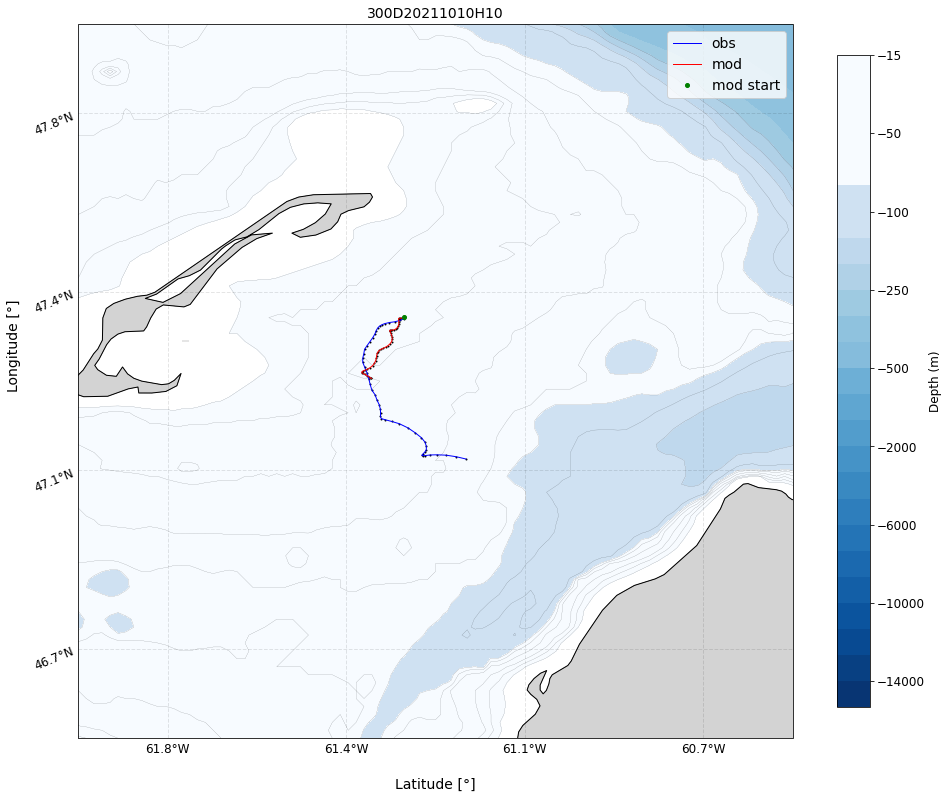

In [30]:
# This is where I'm doing the actual plot:
#import datetime
#print("Current date and time: ", str(datetime.datetime.now()))

################################
# create figure object
################################
# Create a figure object
fig = plt.figure(figsize=(16, 16))

# It's possible to use other projections, but right now it seems that there's issues using anything other than PlateCarree()
# for plotting the gridlines (the plot projection and the data projection are not the same thing). For example, it's possible
# to use projection=ccrs.Mercator() to set up the axis, then use transform=ccrs.PlateCarree() for the plotting/gridlines. 
# But, using proj=LambertConformal and transform = PlateCarree() plots the meridians in the center of the plot. I still 
# don't understand the ramifications of not using projection = transform, so this is something that should be addressed in 
# a later iteration. See more details on the difference between projection and transform here:
# https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html
dataproj = ccrs.PlateCarree()
proj = ccrs.PlateCarree()
#proj = ccrs.Mercator()
#proj = ccrs.LambertConformal(central_longitude=data_bbox_info['meanlon'], central_latitude=data_bbox_info['minlat'])

# Generate axes using Cartopy
ax = fig.add_subplot(1,1,1, projection=proj)

################################
# plot extent
################################
bbox_very_wide = (-80, -10, 20, 89)
bbox_wide = (-68, -54, 40, 54)
bbox_norm = (-62, -60.5, 46.5, 48)
bbox_tight = (-61.5, -61, 47, 47.5)

all_lons = modlon + obslon
all_lats = modlat + modlon
bbox_data = (
    np.nanmin(all_lons), 
    np.nanmax(all_lons), 
    np.nanmin(all_lats), 
    np.nanmax(all_lats)
)

# Zoom into a specific area 
bbox = bbox_norm
ax.set_extent(bbox, crs=dataproj) 

################################
# bathymetry
################################
plot = streamlined_plot_bathymetry(
    bathymetry_file, 
    ax, bbox, 
    add_contourf=True, 
    colorbar_visible=True, 
    add_contours=True)

################################
# ocean mask
################################
# Add ocean mask
#ax.add_feature(
#    cfeature.OCEAN.with_scale('10m'), 
#    zorder=0, 
#    alpha=0.5, 
#    edgecolor='black', 
#    facecolor='lightblue'
#)

# this version seems to give some version of a bathymetry?
#ax.add_feature(
#    cfeature.OCEAN.with_scale('10m'),
#    facecolor='paleturquoise',
#    alpha=0.4
#    )

################################
# coastlines and land
################################
# Add coastlines and land
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')
ax.add_feature(cfeature.LAND, facecolor="lightgrey", edgecolor='black', linewidth=0.2, alpha=1.0)
ax.add_feature(cfeature.LAKES, facecolor='lightgrey')

################################
# plot data
################################
# modify the plot by adding a scatterplot over the map
plt.scatter(x=obslon, y=obslat, color="black", s=1, alpha=1, transform=dataproj)
plt.plot(obslon, obslat, color='blue', linewidth=1, transform=dataproj, label='obs')

# mod track
plt.scatter(x=modlon, y=modlat, color="black", s=1, alpha=1, transform=proj)
plt.plot(modlon, modlat, color='red', linewidth=1, transform=dataproj, label='mod')
plt.plot(
    mod_start_lon[0], 
    mod_start_lat[0], 
    ms=4, ls='', 
    marker='o', 
    color='green', 
    linewidth=1, 
    transform=dataproj, 
    label='mod start'
)

################################
# gridlines
################################
draw_parallels_and_meridians(ax, bbox, dataproj=dataproj)

################################
# titles, labels and annotations
################################
plt.title(buoyid, fontsize=14)
plt.legend(fontsize=14)

## Add a text annotation to the the bottom right corner.
#from matplotlib.offsetbox import AnchoredText
#annotation_str = 'using proj = ' + str(proj) + ' and\ndataproj = ' + str(dataproj)
#text = AnchoredText(annotation_str, loc=4, prop={'size': 12}, frameon=True)
#ax.add_artist(text)

plt.show()
